EPOCH_NUM_arr = [2000]
BATCH_SIZE = 32
L_hidden = 64
lmbda = 5 / 10000 
LR_arr = [0.03]#[0.03, 0.01, 0.1, 0.5]

# Best
beta_arr = [1]#, 3, 9]
rho_arr = [0.3]
alpha = 0.85

# Best without KL divergence
beta_arr = [0]
alpha = 0.85
i = 0

In [2]:
import h5py as h5
import numpy as np
from matplotlib import pyplot as plt
import pathlib

In [3]:
# Import datasets
f = h5.File("assign3_data1.h5", "r")

# Convert them to np array
imgs = np.array(f['data'])
f.close()

images = 0.2126 * imgs[:, 0, :, :] + 0.7152 * imgs[:, 1, :, :] + 0.0722 * imgs[:, 2, :, :]
images = images.reshape((images.shape[0], images.shape[1]**2))
images = images - images.mean(axis=1).reshape((images.shape[0], 1))
for i, image in enumerate(images):
    images[i] = np.clip(images[i], a_min=0.1, a_max=0.9)
X_train = images

In [4]:
def sigmoid(X):
    return 1 / (1 + np.exp(-1 * X))

def sigmoid_backward(X):
    return np.multiply(X, 1 - X)

In [5]:
img = images[0]
img.shape

(256,)

In [6]:
def forward(X, W):
    A = sigmoid(X.dot(W['W']) + W['b_1'])
    O = A.dot(W['W'].transpose()) + W['b_2']
    return A, O

In [7]:
def backward(x, A, O, W, params):
    W_grad = {'W': 0, 'b_1': 0, 'b_2': 0}
    delta_o = O - x
    W_grad['W'] += (A.transpose().dot(delta_o)).transpose() / x.shape[0]
    W_grad['b_2'] += np.ones((A.shape[0], 1)).transpose().dot(delta_o) / x.shape[0]
    
    e = delta_o.dot(W['W'])
    delta_a = np.multiply(e, sigmoid_backward(A))
    W_grad['W'] += x.transpose().dot(delta_a) / x.shape[0]
    W_grad['b_1'] += np.ones((x.shape[0], 1)).transpose().dot(delta_a) / x.shape[0]
    
    W_grad['W'] += 2 * params['lmbda'] * W['W']
    
    P = np.sum(A, axis=0).reshape((1, A.shape[1])) / x.shape[0]
    Q = np.multiply(P - params['rho'], np.multiply(1/P, 1/(1-P) ) ) / x.shape[0]
    W_grad['W'] += params['beta'] * np.multiply(x.transpose().dot(sigmoid_backward(A)), Q)
    W_grad['b_1'] += params['beta'] * np.multiply(np.ones((x.shape[0], 1)).transpose().dot(sigmoid_backward(A)), Q)
    
    return W_grad

In [8]:
def calculate_loss(X, A, O, W, params):
    J = 0
    dif = O - X
    dif_square = np.multiply(dif, dif)
    J += np.sum(dif_square) / (2*X.shape[0])
    
    
    W_square = np.multiply(W['W'], W['W'])
    J += params['lmbda'] * np.sum(W_square)
    rho = params['rho']
    p_hat = np.sum(A, axis=0) / A.shape[0]
    KL = - 1 * ( rho * np.sum(np.log(p_hat)) + (1 - rho) * np.sum(np.log(1 - p_hat)) )
    
    KL += params['Lhid'] * (rho*np.log(rho) + (1-rho)*np.log(1-rho))
    J += params['beta'] * KL
    
    return J

In [9]:
def aeCost(W, X, params):
    A, O = forward(X, W)
    J_grad = backward(X, A, O, W, params)
    J = calculate_loss(X, A, O, W, params)
    return J, J_grad

In [10]:
def initialize_weights(shape):
    t = (6/(shape[0]+shape[1]))**(1/2)
    W = np.random.uniform(low=-1*t, high=t, size=shape)
    #b_1 = np.random.uniform(low=-1*t, high=t, size=(1, shape[1]))
    #b_2 = np.random.uniform(low=-1*t, high=t, size=(1, shape[0]))
    b_1 = np.zeros((1,shape[1]))
    b_2 = np.zeros((1, shape[0]))
    
    return {'W': W, 'b_1': b_1, 'b_2': b_2}
def plot_graph(funcs, labels, title, xlabel, ylabel):
    colors = ['black', 'blue', 'red', 'green']
    min_epoch = 2000
    for func in funcs:
        if len(func) < min_epoch:
            min_epoch = len(func)
    for i, func in enumerate(funcs):
        plt.plot(range(min_epoch), func[:min_epoch], color=colors[i], label=labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [11]:
def train(EPOCH_NUM, BATCH_SIZE, LR, L_hidden, alpha, lmbda, beta, rho, X_train): 
    print(f'Train for {EPOCH_NUM}-{BATCH_SIZE}-{LR}-{L_hidden}-{lmbda}-{beta}-{rho}')
    params = {}
    params['Lin'] = X_train.shape[1]
    params['Lhid'] = L_hidden
    params['lmbda'] = lmbda
    params['beta'] = beta
    params['rho'] = rho
            
    W = initialize_weights((X_train.shape[1], L_hidden)) # initialize the weights

    train_loss = []

    delta_prev = None # For momentum
    batch_num = int(np.ceil(X_train.shape[0] / BATCH_SIZE))
    for epoch in range(EPOCH_NUM):
        if epoch > 0 and epoch % 20 == 0: # Report metrics
            print('Epoch:', epoch)
            print('Train Loss:', train_loss[-1])
            DATA_DIR = f'{L_hidden}_{lmbda}_{rho}_{beta}_{LR}'
            pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
            visualize_weights(W['W'], f'{L_hidden}_{lmbda}_{rho}_{beta}_{LR}/{epoch}_{train_loss[-1]}')
        # Shuffle dataset
        perm = np.random.permutation(X_train.shape[0])
        shuffled_X = X_train[perm]

        totalLoss = 0

        beginning = 0

        for i in range(batch_num):
            if i < batch_num - 1:
                X = shuffled_X[beginning: beginning + BATCH_SIZE] 
            else:
                X = shuffled_X[beginning: ] 
            beginning += BATCH_SIZE
            
            ####### Calculate activations and errors ############
            J, J_grad = aeCost(W, X, params)
            totalLoss += J # Loss calculation
            ##### Delta calculations for momentum ######
            delta_W = -1 * LR * J_grad['W']
            delta_b_1 = -1 * LR * J_grad['b_1']
            delta_b_2 = -1 * LR * J_grad['b_2']
            if delta_prev != None:
                delta_W += alpha * delta_prev['W']
                delta_b_1 += alpha * delta_prev['b_1']
                delta_b_2 += alpha * delta_prev['b_2']
            delta_prev = {'W': delta_W, 'b_1': delta_b_1, 'b_2': delta_b_2}
            ###### Update weights ###############
            W['W'] = W['W'] + delta_W
            W['b_1'] = W['b_1'] + delta_b_1
            W['b_2'] = W['b_2'] + delta_b_2
            #####################################
        train_loss.append(totalLoss / X_train.shape[0])
        
    return W, train_loss

In [25]:
def loss(a,b):
    return a + 3*b

eps = 0.0001
a = 3
b = 4
der = (loss(a-eps, b-eps) - loss(a+eps, b+eps)) / (2*eps)
der

-3.9999999999995595

In [26]:
EPOCH_NUM = 2000
BATCH_SIZE = 32
LR = 0.001 
L_hidden = 64
lmbda = 5 / 10000 
beta = 0.5
rho = 0.5
alpha = 0
check(EPOCH_NUM, BATCH_SIZE, LR, L_hidden, alpha, lmbda, beta, rho, X_train)

NameError: name 'check' is not defined

Train for 2000-32-0.05-32-0.0005-0-0.001
Epoch: 20
Train Loss: 0.07232113027926705


IndexError: index 32 is out of bounds for axis 1 with size 32

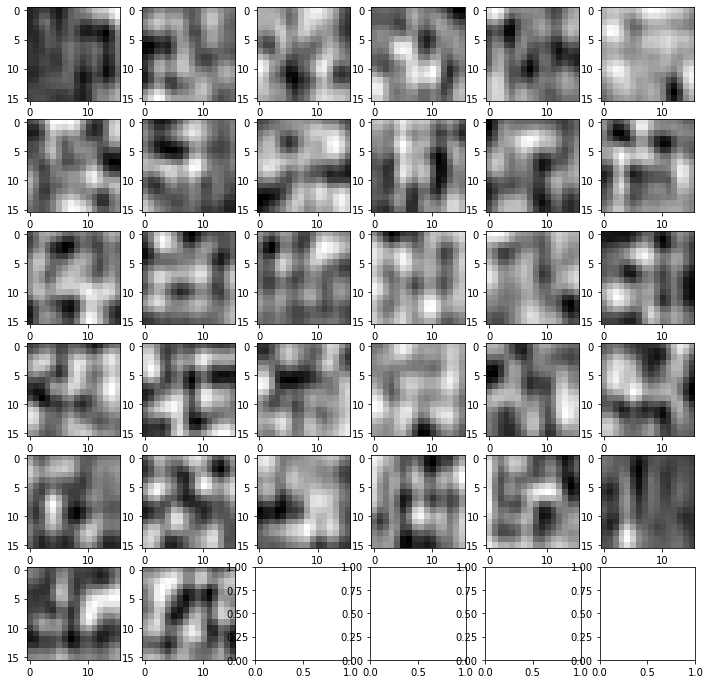

In [35]:
EPOCH_NUM = 2000
BATCH_SIZE = 32
LR = 0.05 
L_hidden = 32
lmbda = 5 / 10000 
beta = 0
rho = 0.001
alpha = 0
W = train(EPOCH_NUM, BATCH_SIZE, LR, L_hidden, alpha, lmbda, beta, rho, X_train)
visualize_weights(W)

In [49]:
EPOCH_NUM_arr = [2000]
BATCH_SIZE = 32
L_hidden = 64
lmbda = 5 / 10000 
LR_arr = [0.03]#[0.03, 0.01, 0.1, 0.5]
beta_arr = [0.1]#, 3, 9]
rho_arr = [0.3]
alpha = 0.85
i = 0
for LR in LR_arr:
    for beta in beta_arr:
        for rho in rho_arr:
            for EPOCH_NUM in EPOCH_NUM_arr:
                i += 1
                if i > 0:
                    W, _ = train(EPOCH_NUM, BATCH_SIZE, LR, L_hidden, alpha, lmbda, beta, rho, X_train)
                    #visualize_weights(W['W'], f'{EPOCH_NUM}_{rho}_{beta}_{LR}')

Train for 2000-32-0.03-64-0.0005-0.1-0.3
Epoch: 20
Train Loss: 0.041664506268978066
Epoch: 40
Train Loss: 0.03973084402750105
Epoch: 60
Train Loss: 0.03898076452351237
Epoch: 80
Train Loss: 0.038593788967584156
Epoch: 100
Train Loss: 0.03830883553209809
Epoch: 120
Train Loss: 0.03810082210492291
Epoch: 140
Train Loss: 0.0379313342588207
Epoch: 160
Train Loss: 0.0378423155969154
Epoch: 180
Train Loss: 0.037752263970571395
Epoch: 200
Train Loss: 0.037696184384811815
Epoch: 220
Train Loss: 0.03762192049372458
Epoch: 240
Train Loss: 0.03764914650434538
Epoch: 260
Train Loss: 0.03762968110053687
Epoch: 280
Train Loss: 0.03762150071315205
Epoch: 300
Train Loss: 0.03755218204911227
Epoch: 320
Train Loss: 0.03763883287462811
Epoch: 340
Train Loss: 0.037602403794348885
Epoch: 360
Train Loss: 0.037536170999340736
Epoch: 380
Train Loss: 0.03747201955844737
Epoch: 400
Train Loss: 0.0374846943454853
Epoch: 420
Train Loss: 0.03756005339760208


/Users/shbilisim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


Epoch: 440
Train Loss: 0.03754409497197571
Epoch: 460
Train Loss: 0.037528542176659574
Epoch: 480
Train Loss: 0.037510630778190286
Epoch: 500
Train Loss: 0.037505433383456036
Epoch: 520
Train Loss: 0.037488438593069294
Epoch: 540
Train Loss: 0.037474632336600595
Epoch: 560
Train Loss: 0.03744083789918839
Epoch: 580
Train Loss: 0.037477904099815225
Epoch: 600
Train Loss: 0.0374988762367706
Epoch: 620
Train Loss: 0.03746083076699636
Epoch: 640
Train Loss: 0.03748022849080706
Epoch: 660
Train Loss: 0.03751149204704101
Epoch: 680
Train Loss: 0.037438404958679214
Epoch: 700
Train Loss: 0.03743038710115345
Epoch: 720
Train Loss: 0.037428924076556
Epoch: 740
Train Loss: 0.03749368058937403
Epoch: 760
Train Loss: 0.03738757457014725
Epoch: 780
Train Loss: 0.03741805356130908
Epoch: 800
Train Loss: 0.037448558338212305
Epoch: 820
Train Loss: 0.03742464581487764
Epoch: 840
Train Loss: 0.03743066285172003
Epoch: 860
Train Loss: 0.0374307535257007
Epoch: 880
Train Loss: 0.037411388259992476
Epoch:

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ffa3c0019d8> (for post_execute):


KeyboardInterrupt: 

In [14]:
EPOCH_NUM_arr = [1000]
BATCH_SIZE = 32
L_hidden_arr = [16, 49, 100]
lmbda_arr = [0, 4 / 10000, 0.001]
LR_arr = [0.03]
beta = 1
rho = 0.3
alpha = 0.85
i = 0
for LR in LR_arr:
    for lmbda in lmbda_arr:
        for L_hidden in L_hidden_arr:
            for EPOCH_NUM in EPOCH_NUM_arr:
                i += 1
                if i > 0:
                    W, _ = train(EPOCH_NUM, BATCH_SIZE, LR, L_hidden, alpha, lmbda, beta, rho, X_train)
                    visualize_weights(W['W'], f'{EPOCH_NUM}_{rho}_{beta}_{LR}')

Train for 1000-32-0.03-16-0-1-0.3
Epoch: 20
Train Loss: 0.1046484713707208
Epoch: 40
Train Loss: 0.1041562231779325
Epoch: 60
Train Loss: 0.10385511040508988
Epoch: 80
Train Loss: 0.10375593049518665
Epoch: 100
Train Loss: 0.10377333723959388
Epoch: 120
Train Loss: 0.10351246399761642
Epoch: 140
Train Loss: 0.10394767681866937
Epoch: 160
Train Loss: 0.10399592472620586
Epoch: 180
Train Loss: 0.10396169289899397
Epoch: 200
Train Loss: 0.10393715592908845
Epoch: 220
Train Loss: 0.10389712909705476
Epoch: 240
Train Loss: 0.10389348902087048
Epoch: 260
Train Loss: 0.10393228653173518
Epoch: 280
Train Loss: 0.10383951177147657
Epoch: 300
Train Loss: 0.103953737547652
Epoch: 320
Train Loss: 0.10381084778489943
Epoch: 340
Train Loss: 0.10381034038769651
Epoch: 360
Train Loss: 0.10370578055990187


<ipython-input-12-583d12f0c314>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax_array = plt.subplots(rows, cols,figsize=(12,12),squeeze=False)


Epoch: 380
Train Loss: 0.1042493111824802
Epoch: 400
Train Loss: 0.10406832332665181
Epoch: 420
Train Loss: 0.10365308571658258
Epoch: 440
Train Loss: 0.10378470205624682
Epoch: 460
Train Loss: 0.10386324142830687
Epoch: 480
Train Loss: 0.10358091010663573
Epoch: 500
Train Loss: 0.10367651671266245
Epoch: 520
Train Loss: 0.10369324226306846
Epoch: 540
Train Loss: 0.10363981596244047
Epoch: 560
Train Loss: 0.10367022796899202
Epoch: 580
Train Loss: 0.10391399143480577
Epoch: 600
Train Loss: 0.10372173098034583
Epoch: 620
Train Loss: 0.10387403190829451
Epoch: 640
Train Loss: 0.10382434788869357
Epoch: 660
Train Loss: 0.10395494771237683
Epoch: 680
Train Loss: 0.10380943206638345
Epoch: 700
Train Loss: 0.10363086011570917
Epoch: 720
Train Loss: 0.10379742881539844
Epoch: 740
Train Loss: 0.10395240412515214
Epoch: 760
Train Loss: 0.10365638279251554
Epoch: 780
Train Loss: 0.10380135478642498
Epoch: 800
Train Loss: 0.10376824502917334
Epoch: 820
Train Loss: 0.10379307125492857
Epoch: 840
T

Epoch: 200
Train Loss: 0.055249249742350945
Epoch: 220
Train Loss: 0.0550163259219119
Epoch: 240
Train Loss: 0.05478499424123871
Epoch: 260
Train Loss: 0.05490215374818484
Epoch: 280
Train Loss: 0.05461512962874532
Epoch: 300
Train Loss: 0.05482684046674047
Epoch: 320
Train Loss: 0.05491628042869481
Epoch: 340
Train Loss: 0.05467697942391123
Epoch: 360
Train Loss: 0.05508572054701605
Epoch: 380
Train Loss: 0.054565306970440576
Epoch: 400
Train Loss: 0.05470151130914632
Epoch: 420
Train Loss: 0.05441574302593712
Epoch: 440
Train Loss: 0.05503518099802639
Epoch: 460
Train Loss: 0.054897818241990706
Epoch: 480
Train Loss: 0.05484966096819142
Epoch: 500
Train Loss: 0.054969081286160126
Epoch: 520
Train Loss: 0.054406225630915094
Epoch: 540
Train Loss: 0.055164255161867
Epoch: 560
Train Loss: 0.05453257290117651
Epoch: 580
Train Loss: 0.05421988892909816
Epoch: 600
Train Loss: 0.05504325922175128
Epoch: 620
Train Loss: 0.054783684985511324
Epoch: 640
Train Loss: 0.05463585954844567
Epoch: 6

Epoch: 20
Train Loss: 0.04198850026618536
Epoch: 40
Train Loss: 0.040330969024677706
Epoch: 60
Train Loss: 0.03939370748968275
Epoch: 80
Train Loss: 0.03926063954242956
Epoch: 100
Train Loss: 0.038952446798262666
Epoch: 120
Train Loss: 0.03870723677203543
Epoch: 140
Train Loss: 0.038815591238606145
Epoch: 160
Train Loss: 0.03832710943351867
Epoch: 180
Train Loss: 0.037747518753872694
Epoch: 200
Train Loss: 0.03842534772664897
Epoch: 220
Train Loss: 0.038409194497237106
Epoch: 240
Train Loss: 0.03832778516595314
Epoch: 260
Train Loss: 0.03838463496938278
Epoch: 280
Train Loss: 0.037781614182443586
Epoch: 300
Train Loss: 0.0380557411464524
Epoch: 320
Train Loss: 0.03763328364388199
Epoch: 340
Train Loss: 0.037716379476163756
Epoch: 360
Train Loss: 0.038784619425263844
Epoch: 380
Train Loss: 0.038306506585796866
Epoch: 400
Train Loss: 0.037970481265429554
Epoch: 420
Train Loss: 0.03826914631576532
Epoch: 440
Train Loss: 0.03789327971023661
Epoch: 460
Train Loss: 0.03812781505821318
Epoch:

In [ ]:
EPOCH_NUM = 2000
BATCH_SIZE = 32
LR = 0.01 
L_hidden = 64
lmbda = 5 / 10000 
beta = 1
rho = 0
alpha = 0
W = train(EPOCH_NUM, BATCH_SIZE, LR, L_hidden, alpha, lmbda, beta, rho, X_train)
visualize_weights(W)

In [ ]:
EPOCH_NUM = 2000
BATCH_SIZE = 32
LR = 0.01 
L_hidden = 64
lmbda = 5 / 10000 
beta = 0.2
rho = 0.2
alpha = 0
W = train(EPOCH_NUM, BATCH_SIZE, LR, L_hidden, alpha, lmbda, beta, rho, X_train)
visualize_weights(W)

In [12]:
def visualize_sample_images():
    sample = np.random.choice(X_train.shape[0], 200, replace=False)
    visualize_images(imgs[sample], 200, True, "RGB Format")
    visualize_images(X_train[sample], 200, False, "Normalized version")

In [154]:
def check(EPOCH_NUM, BATCH_SIZE, LR, L_hidden, alpha, lmbda, beta, rho, X_train): 
    params = {}
    params['Lin'] = X_train.shape[1]
    params['Lhid'] = L_hidden
    params['lmbda'] = lmbda
    params['beta'] = beta
    params['rho'] = rho
    W = initialize_weights((X_train.shape[1], L_hidden)) # initialize the weights
    X = X_train[:32]
    epsilon = 0.0000001
    W_epsilon = {}
    W_epsilon['b_1'] = W['b_1']
    W_epsilon['b_2'] = W['b_2']
    W_epsilon['W'] = W['W'] - epsilon
    W_plus = {}
    W_plus['b_1'] = W['b_1']
    W_plus['b_2'] = W['b_2']
    W_plus['W'] = W['W'] + epsilon
    J_1, grad = aeCost(W_epsilon, X, params)
    _, J_grad = aeCost(W, X, params)
    J_2, grad = aeCost(W_plus, X, params)
    expected = np.sum(J_grad['W'])
    real = (J_2 - J_1)/(2*epsilon)
    print((real-expected)/(real+expected))
    W_epsilon = {}
    W_epsilon['b_1'] = W['b_1'] - epsilon
    W_epsilon['b_2'] = W['b_2']
    W_epsilon['W'] = W['W']
    W_plus = {}
    W_plus['b_1'] = W['b_1'] + epsilon
    W_plus['b_2'] = W['b_2']
    W_plus['W'] = W['W']
    J_1, grad = aeCost(W_epsilon, X, params)
    _, J_grad = aeCost(W, X, params)
    J_2, grad = aeCost(W_plus, X, params)
    expected = np.sum(J_grad['b_1'])
    real = (J_2 - J_1)/(2*epsilon)
    print((real-expected)/(real+expected))
    W_epsilon = {}
    W_epsilon['b_1'] = W['b_1']
    W_epsilon['b_2'] = W['b_2'] - epsilon
    W_epsilon['W'] = W['W']
    W_plus = {}
    W_plus['b_1'] = W['b_1']
    W_plus['b_2'] = W['b_2'] + epsilon
    W_plus['W'] = W['W']
    J_1, grad = aeCost(W_epsilon, X, params)
    _, J_grad = aeCost(W, X, params)
    J_2, grad = aeCost(W_plus, X, params)
    expected = np.sum(J_grad['b_2'])
    real = (J_2 - J_1)/(2*epsilon)
    print((real-expected)/(real+expected))
    

In [12]:
def visualize_weights(W, name):
    size = W.shape[1]
    rows = int(np.round(size**(1/2)))
    cols = int(np.ceil(size / rows))
    fig, ax_array = plt.subplots(rows, cols,figsize=(12,12),squeeze=False)
    for i,ax_row in enumerate(ax_array):
        for j,axes in enumerate(ax_row):
            if i*cols+j == size:
                break
            axes.imshow(W[:, i*cols+j].reshape((16, 16)), cmap='gray')
    plt.savefig(f'{name}.png', bbox_inches='tight')

In [22]:
def visualize_images(imgs, size, rgb, title):
    visualize_25_images(imgs[:25], size, rgb, title)
    visualize_25_images(imgs[25:50], size, rgb, title)
    visualize_25_images(imgs[50:75], size, rgb, title)
    visualize_25_images(imgs[75:100], size, rgb, title)
    visualize_25_images(imgs[100:125], size, rgb, title)
    visualize_25_images(imgs[125:150], size, rgb, title)
    visualize_25_images(imgs[150:175], size, rgb, title)
    visualize_25_images(imgs[175:], size, rgb, title)
    

In [23]:
def visualize_25_images(imgs, size, rgb, title):
    rows = 5
    cols = 5
    fig, ax_array = plt.subplots(rows, cols,figsize=(12,12),squeeze=False)
    for i,ax_row in enumerate(ax_array):
        for j,axes in enumerate(ax_row):
            if i*cols+j == size:
                break
            if rgb:
                im = np.zeros((16,16,3))
                im[:,:,0] = imgs[i*cols+j, 0,:,:]
                im[:,:,1] = imgs[i*cols+j, 1,:,:]
                im[:,:,2] = imgs[i*cols+j, 2,:,:]
                axes.imshow(im)
            else:
                axes.imshow(imgs[i*cols+j].reshape((16, 16)), cmap='gray')
            axes.set_xticklabels([])
            axes.set_yticklabels([])
    #fig.suptitle(title)
    plt.axis("off")
    plt.show()

In [24]:
visualize_sample_images()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [24]:
imgs.shape
i = 0

In [14]:
i = 25
sample_image = np.zeros((16,16,3))
sample_image[:,:,0] = imgs[i,0,:,:]
sample_image[:,:,1] = imgs[i,1,:,:]
sample_image[:,:,2] = imgs[i,2,:,:]
import matplotlib.pyplot as plt
plt.imshow(sample_image)
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [20]:
sample_image.max()

1.492340087890625

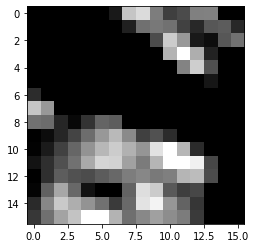

In [41]:
plt.imshow(np.clip(X_train[25].reshape((16,16)), a_min=0.1, a_max=0.9), cmap='gray')
plt.savefig('ex.png', bbox_inches='tight')

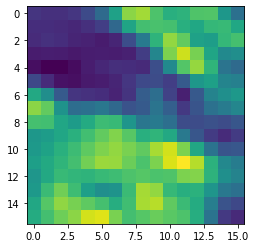

In [60]:
plt.imshow(X_train[25].reshape((16,16)))
plt.show()

In [9]:
norm_imgs = imgs / 8
imgs.min()

-7.0513735

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


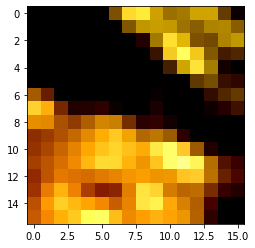

In [11]:
i = 25
sample_image = np.zeros((16,16,3))
sample_image[:,:,0] = imgs[i,0,:,:]
sample_image[:,:,1] = imgs[i,1,:,:]
sample_image[:,:,2] = imgs[i,2,:,:]
import matplotlib.pyplot as plt
plt.imshow(sample_image)
plt.show()

In [ ]:
EPOCH_NUM_arr = [2000]
BATCH_SIZE = 32
L_hidden = 64
lmbda = 5 / 10000 
LR_arr = [0.03]#[0.03, 0.01, 0.1, 0.5]
beta_arr = [0.1]#, 3, 9]
rho_arr = [0.3]
alpha = 0.85
i = 0
for LR in LR_arr:
    for beta in beta_arr:
        for rho in rho_arr:
            for EPOCH_NUM in EPOCH_NUM_arr:
                i += 1
                if i > 0:
                    W, _ = train(EPOCH_NUM, BATCH_SIZE, LR, L_hidden, alpha, lmbda, beta, rho, X_train)
                    #visualize_weights(W['W'], f'{EPOCH_NUM}_{rho}_{beta}_{LR}')